# Constraint Learning 

### Librairies

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')
%matplotlib inline 


### Importing the NSL_KDD dataset


In [2]:
data_train = pd.read_csv('../datasets/NSL-KDD/KDDTrain+.txt')
data_test = pd.read_csv('../datasets/NSL-KDD/KDDTest+.txt')


columns = (['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot'
,'num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells',
'num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate',
'rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count'
,'dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate',
'dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','outcome','level'])

data_train.columns = columns
data_test.columns = columns

### Exploring the data

In [3]:
print(data_train.shape)
print(data_test.shape)


(125972, 43)
(22543, 43)


In [4]:
data_train.info()
#: no missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

In [5]:
data_train.head()


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,level
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.00,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.00,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.00,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21
3,0,tcp,http,SF,199,420,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,30,32,0.0,0.0,0.0,0.0,1.00,0.00,0.09,255,255,1.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,normal,21
4,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,121,19,0.0,0.0,1.0,1.0,0.16,0.06,0.00,255,19,0.07,0.07,0.00,0.00,0.00,0.00,1.0,1.00,neptune,21


In [6]:
## The 'level' and 'outcome' features are the two output of features
data_train.describe().style.background_gradient(cmap='Blues').set_properties(**{'font-family':'Segoe UI'})


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,level
count,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,45567.100824,19779.271433,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,0.001342,0.001103,0.302194,0.012669,0.000413,0.004096,0.000000,0.000008,0.009423,84.108207,27.738093,0.284487,0.282488,0.119959,0.121184,0.660925,0.063053,0.097322,182.149200,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5870354.480801,4021285.112114,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,0.036603,0.045155,24.399715,0.483937,0.022181,0.099370,0.000000,0.002817,0.096613,114.508828,72.636092,0.446457,0.447024,0.320437,0.323648,0.439624,0.180315,0.259831,99.206565,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,276.000000,516.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1379963888.000000,1309937401.000000,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.000000,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [7]:
## change outputs from natural to boolean
data_train.loc[data_train['outcome'] == "normal", "outcome"] = 'normal'
data_train.loc[data_train['outcome'] != 'normal', "outcome"] = 'attack'

data_test.loc[data_test['outcome'] == "normal", "outcome"] = 'normal'
data_test.loc[data_test['outcome'] != 'normal', "outcome"] = 'attack'

In [8]:
data_train['outcome'].head()
data_train['outcome'].describe()


count     125972
unique         2
top       normal
freq       67342
Name: outcome, dtype: object

In [9]:
def pie_plot(df, cols_list, rows, cols):
    fig, axes = plt.subplots(rows, cols)
    for ax, col in zip(axes.ravel(), cols_list):
        df[col].value_counts().plot(ax=ax, kind='pie', figsize=(15, 15), fontsize=10, autopct='%1.0f%%')
        ax.set_title(str(col), fontsize = 12)
    plt.show()


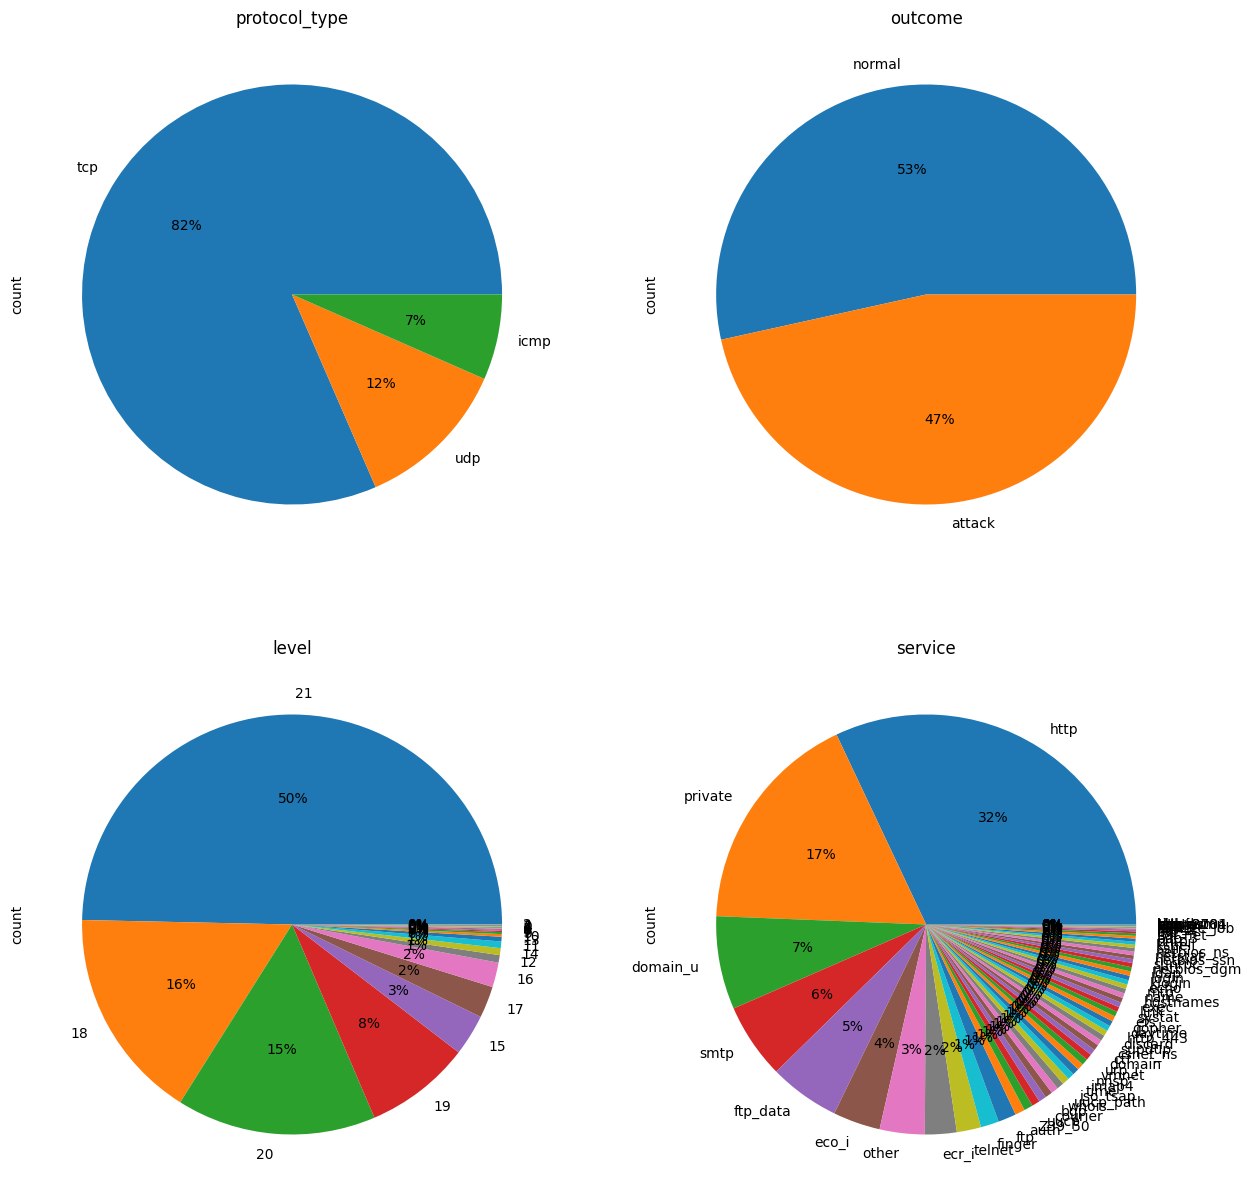

In [10]:
pie_plot(data_train, ['protocol_type', 'outcome', 'level', 'service'], 2, 2)


In [11]:
'''    
  @-> amount of label(category) of each features   
'''
def label_count(df, target_feature):
  label_counts = df.nunique()
  # correlations = df.corr()[target_feature].sort_values(ascending=False)
  return pd.DataFrame({
      'label_count': label_counts,
      # 'correlation': correlations
  })

result = label_count(data_train, 'outcome')
result


,label_count
duration,2981
protocol_type,3
service,70
flag,11
src_bytes,3341
dst_bytes,9326
land,2
wrong_fragment,3
urgent,4
hot,28


In [12]:
s = pd.Series()
for column in data_train.columns:
  s[column] = data_train[column].dtype

s.unique()


array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [13]:
from scipy.stats import pearsonr

'''    
  @-> correlation coefficient   
'''
df = pd.DataFrame({
    "feature_0": [-1, -1, 0, 0, -1],
    "feature_1": [1, 2, 3, 4, 5],
    "feature_2": [0, 0, 1, 1, 0],
    'feature_3': ['a', 'a', 'b', 'b', 'c'],
    'feature_4': ['c', 'f', 'c', 'd', 'e'],
    "feature_5": [1.2, 1.3, 1.4, .9, .1],
    'target_feature': [1, 1, 0, 0, 1]
})

def pearson_r(df, target_feature):
  pearson = pd.Series()

  categories = {'num': [],'str': []}
  targeted = pd.Series(pd.factorize(df[target_feature])[0]).astype(float)
  for column in df.columns:
    corr = 0
    # if column != target_feature:
    if df[column].dtype not in ['int64', 'float64']:
      categories['str'].append(column)
      factorized = pd.Series(pd.factorize(df[column])[0]).astype(float)
      # corr = factorized.corr(targeted, method='pearson', min_periods=1)
      corr, pvalue = pearsonr(factorized, targeted)
    else:
      categories['num'].append(column)
      df[column].astype(float)
      # corr = df[column].corr(targeted, method='pearson', min_periods=1)
      corr, pvalue = pearsonr(df[column], targeted)
      
    pearson[column] = corr

  return categories, pearson

print(pd.__version__)
types, pearson = pearson_r(data_train, 'outcome')
pearson.sort_values(ascending=False)


2.0.1


outcome                        1.000000
dst_host_srv_serror_rate       0.654984
dst_host_serror_rate           0.651840
serror_rate                    0.650651
srv_serror_rate                0.648287
count                          0.576442
flag                           0.479868
dst_host_count                 0.375051
service                        0.321788
protocol_type                  0.281357
srv_rerror_rate                0.253502
dst_host_srv_rerror_rate       0.253428
rerror_rate                    0.253395
dst_host_rerror_rate           0.252562
dst_host_diff_srv_rate         0.242897
diff_srv_rate                  0.203658
wrong_fragment                 0.095905
dst_host_same_src_port_rate    0.092445
dst_host_srv_diff_host_rate    0.062330
duration                       0.048785
land                           0.007191
src_bytes                      0.005921
dst_bytes                      0.004118
srv_count                      0.000768
is_host_login                 -0.002629


In [14]:
print(pd.factorize(df['feature_3'])[0])
print(pd.factorize(df['feature_4'])[0])
print((pd.factorize(df['feature_4'])))
print(df['feature_1'].dtype)
print(df['feature_5'].dtype)
print(df['target_feature'].dtype)

[0 0 1 1 2]
[0 1 0 2 3]
(array([0, 1, 0, 2, 3]), Index(['c', 'f', 'd', 'e'], dtype='object'))
int64
float64
int64


### Preprocessing The Dataset

In [15]:
def Scaling(df_num, cols):
    std_scaler = RobustScaler()
    std_scaler_temp = std_scaler.fit_transform(df_num)
    std_df = pd.DataFrame(std_scaler_temp, columns =cols)
    return std_df

In [16]:
cat_cols = ['is_host_login','protocol_type','service','flag','land', 'logged_in','is_guest_login', 'level', 'outcome']
def preprocess(dataframe):
    df_num = dataframe.drop(cat_cols, axis=1)
    num_cols = df_num.columns
    scaled_df = Scaling(df_num, num_cols)
    
    dataframe.drop(labels=num_cols, axis="columns", inplace=True)
    dataframe[num_cols] = scaled_df[num_cols]
    
    dataframe.loc[dataframe['outcome'] == "normal", "outcome"] = 0
    dataframe.loc[dataframe['outcome'] != 0, "outcome"] = 1
    
    dataframe = pd.get_dummies(dataframe, columns = ['protocol_type', 'service', 'flag'])
    return dataframe



In [17]:
scaled_train = preprocess(data_train)

### Dataset Split (Generating Training and Validation Datasets)

In [18]:
x = scaled_train.drop(['outcome', 'level'] , axis = 1)
y = scaled_train['outcome']
y_reg = scaled_train['level']
y = y.astype('int')

x_train, x_test, y_train, y_test = train_test_split(x, y, shuffle=True, test_size=0.2, random_state=42)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = train_test_split(x, y_reg, shuffle=True, test_size=0.2, random_state=42)

In [19]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(100777, 122)
(100777,)
(25195, 122)
(25195,)


### Visulizing Boolean Matrix

In [20]:
x_train.sample(n=20, random_state=42, replace=False)


,land,logged_in,is_host_login,is_guest_login,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
60915,0,0,0,0,0.0,-0.094203,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.092199,-0.4375,0.00,0.00,0.0,0.0,0.000000,0.000000,0.00,-1.468208,0.012245,0.515789,-0.285714,16.666667,50.0,0.00,0.00,0.00,0.00,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
103996,0,1,0,0,0.0,0.387681,18.445736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.070922,-0.1875,0.00,0.00,0.0,0.0,0.000000,0.000000,0.40,-1.369942,0.783673,0.515789,-0.285714,1.000000,1.5,0.00,0.00,0.00,0.00,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
110244,0,0,0,0,0.0,-0.159420,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.092199,-0.4375,0.00,0.00,1.0,1.0,0.000000,0.000000,0.00,-1.433526,0.783673,0.515789,-0.285714,2.333333,15.0,0.00,0.00,1.00,1.00,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
91319,0,1,0,0,0.0,30.003623,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [21]:
x_train.describe()


,land,logged_in,is_host_login,is_guest_login,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,100777.000000,100777.000000,100777.00000,100777.000000,100777.000000,1.007770e+05,1.007770e+05,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.0,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000,100777.000000
mean,0.000218,0.396926,0.00001,0.009427,287.684749,1.257255e+02,3.874371e+01,0.022237,0.000129,0.203648,0.001221,0.297508,0.001310,0.001111,0.320649,0.013505,0.000427,0.004217,0.0,0.495832,1.228128,0.284382,0.282341,0.119911,0.121303,-0.372317,1.047868,0.096924,-0.422055,0.215916,0.012778,0.890454,2.472209,1.622419,0.284389,0.278271,0.118652,0.120271
std,0.014774,0.489263,0.00315,0.096633,2622.595325,1.800030e+04,8.363073e+03,0.250766,0.015750,2.145381,0.043059,26.295386,0.036168,0.045417,26.699117,0.516542,0.022492,0.100960,0.0,0.810900,4.527404,0.446399,0.446936,0.320424,0.323826,0.482848,2.998846,0.259095,0.573957,0.451859,0.472530,2.680736,5.150211,5.609428,0.444726,0.445559,0.306505,0.319496
min,0.000000,0.000000,0.00000,0.000000,0.000000,-1.594203e-01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.099291,-0.500000,0.000000,0.000000,0.000000,0.000000,-1.098901,0.000000,0.000000,-1.473988,-0.257143,-0.536842,-0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.00000,0.000000,0.000000,-1.594203e-01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,-0.085106,-0.375000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,-1.005780,-0.212245,-0.484211,-0.285714,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010526,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,0.00000,0.000000,0.000000,8.405797e-01,1.019380e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.914894,0.625000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.783673,0.515789,0.714286,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.00000,1.000000,42908.000000,4.999869e+06,2.538638e+06,3.000000,3.000000,77.000000,4.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,3.524823,31.437500,1.000000,1.000000,1.000000,1.000000,0.000000,16.666667,1.000000,0.000000,0.783673,0.515789,14.000000,16.666667,50.000000,1.000000,1.000000,1.000000,1.000000


In [22]:
cat_bool_training_cols = ['is_host_login', 'land', 'logged_in', 'is_guest_login']
cat_bool_ohe_cols = ['protocol_type', 'service', 'flag', 'level', 'outcome']

x_train[cat_bool_training_cols]


,is_host_login,land,logged_in,is_guest_login
86509,0,0,0,0
34925,0,0,0,0
72318,0,0,0,0
11420,0,0,0,0
74271,0,0,0,0
...,...,...,...,...
119879,0,0,0,0
103694,0,0,0,0
860,0,0,1,0
15795,0,0,0,0
